![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

# Normalisation des données

## Mise en situation
Je travaille pour un courtier en crédits (immobilier, consommation, ...) et je souhaite un aperçu rapide du taux que je peux essayer de négocier pour un montant donné, suivant certaines caractéristiques du vendeur.

J'ai pour celà un gros jeu de données, et je fais une descente de gradient. Ca a l'air de marcher, mais que c'est lent...

## Normaliser les données
### C'est quoi ?
Lorsqu'on représente les données sous forme numérique, chaque élément a ses propres caractéristiques.
* Le montant emprunté par exemple, peut varier de 50.000 à 1.000.000 euros
* Les revenus du foyer de l'emprunteur varient plutôt de 1.000 à 10.000 euros
* Le nombre de personnes à charge du foyer va varier entre 1 et 10
* etc...
Toutes ces valeurs ont des échelles très différentes ! 

Il en résulte que lorsqu'on combine linéairement ces valeurs pour sortir un résultat, le meilleur modèle tentera probablement de compenser ces différences d'échelles en les répercutant sur les différents $\theta$. Certaines componsantes vont donc avoir des marges de progressions plus importantes, et la dérivée (le gradient) sera plus forte pour ces composantes-là.

Ca n'empeche pas la convergence, simplement la direction prise à chaque étape n'est pas optimale...

### Visualisation 2D
Pour mieux voir de quoi il retourne, un petit exemple visuel

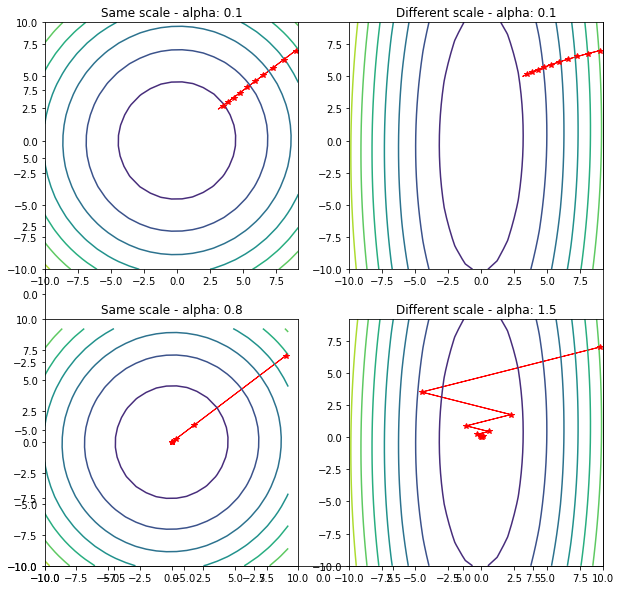

In [2]:
# f(a,b) = 2a + 2b
def f(x): return 2*x[:,0] + 2*x[:,1]
def cost(x, y, theta1, theta2):
    errs =  x[:,0] * theta1 + x[:,1] * theta2 - y
    return np.sum(errs**2)/x.shape[0]

samples = 100
limit = 10
delta = .8

def show_contour(x, y, dy, title, positions, alphas):
    range_theta1 = np.arange(-limit, limit, delta)
    range_theta2 = np.arange(-limit, limit, delta)
    theta1, theta2 = np.meshgrid(range_theta1, range_theta2)
    c=np.zeros((range_theta2.shape[0], range_theta1.shape[0]))

    for i in range(len(range_theta1)):
        for j in range(len(range_theta2)):
            c[j,i] = cost(x, y, range_theta1[i], range_theta2[j])
    plot.xlim(-limit,limit)
    plot.ylim(-limit,limit)
    for p in range(2):
        fig.add_subplot(positions[p])
        alpha = alphas[p]
        plot.title(title + ' - alpha: ' + str(alpha))
        contour = plot.contour(theta1, theta2, c)
        x = 9
        y = 7
        for i in range(10):
            plot.plot(x, y,"r*")
            plot.arrow(x,y,-x*alpha,-y*alpha/dy, color="r")
            x = x - alpha*x
            y = y - alpha*y/dy

fig = plot.figure(figsize=(10,10))
# Cas normalisé : avec a et b compris entre -1 et 1
X = np.random.rand(samples,2)*2-1
Y = f(X).reshape(-1,1)
show_contour(X, Y, 1, 'Same scale', [221, 223], [0.1, 0.8])

# Cas normalisé : avec a entre -3 et 3 et b entre -1 et 1
X = np.random.rand(samples,2)*2-1
X[:,0] *= 3
Y = f(X).reshape(-1,1)
show_contour(X, Y, 3, 'Different scale', [222, 224], [0.1, 1.5])

Ca demande un minimum d'explications :)

Alors les graphiques sont de type "contour"
* on représente une fonction $f$ à deux variables : $f(x,y)$
* les $x$ sont en abscisses, les $y$ en ordonnées
* chaque cercle correspond à un ensemble de points $E=\{(x,y)|f(x,y)=constante\}$, autrement dit sur tout le cercle la fonction a la même valeur

On considère deux composantes de $\theta$ sur ces graphiques qui montrent les contours de la fonction de coût.
* Lorsqu'elles ont la même echelle (figures de gauche) on a des cercles bien concentriques. La descente de gradient progresse dans le bon sens, et on peut même se permettre d'augmenter la valeur de $\alpha$.
* Lorsqu'elles n'ont pas la même echelle (figures de droite) on a des ellipses bien étirées. La descente de gradient progresse en suivant la _normale_ des ellpises, pas forcément vers le centre. La progression est lente et se dirige au final vers le centre, mais plus lentement.
Augmenter la valeur de $\alpha$ ne va pas forcément aider à aller plus vite, on risque de faire des allers-retours encore plus larges

Pour pallier le problème, il faut donc s'assurer que les données soient _normalisées_ : autant que possibles, avoir des données comprises entre 0 et 1

### Technique de normalisation
Pour une mesure donnée, on dispose d'un jeu de valeurs. On va noter:
* $\mu = \frac{1}{m}\sum_{i=1}^m{x_i}$, la moyenne de toutes les valeurs de cette série
* $\sigma = \sqrt{\frac{1}{m}\sum_{i=1}^m{(x_i-\mu)^2}}$, l'écart type des valeurs de cette série

Pour normaliser la série de donnée, on va la transformer ainsi : $X_{norm} = \frac{X - \mu}{\sigma}$

On soustrait la moyenne, puis on divise par l'amplitude : le résultat est une sorte de loi normale (une gaussienne) qui ne déborde pas trop d'entre -1 et 1, plutôt centrée en 0.

## Retour à la mise en situation
### Chargement des données
Je dispose d'un historique des taux en fonction de plusieurs paramètres, dont le montant emprunté, la durée de crédit, le nombre de salaires, etc...

In [3]:
data = np.load('data/d04_data.npy')
Xtrain = data[:,0:-1]
Ytrain = data[:,-1].reshape(-1,1)


On commence par trouver le meilleur modèle, sans normaliser les données

In [4]:
# Trouve le meilleur modèle par rapport à X et Y
def solve_model(X, Y, alpha = 0.001, iterations = 1000) : 
    
    m = X.shape[0]
    
    # On commence par ajouter une colonne x0 = 1
    Xtmp = np.concatenate([np.ones((X.shape[0],1)), X], axis = 1)
    
    # On initialise theta
    theta = np.random.rand(Xtmp.shape[1], 1) * 0.01

    # Puis on calcule theta
    for i in range(iterations):
        grad = np.dot(Xtmp.T, np.dot(Xtmp, theta) - Y) / m
        theta -= alpha * grad
    
    return theta
def cost(X, Y, model):
    m = X.shape[0]
    Xtmp = np.concatenate([np.ones((X.shape[0],1)), X], axis = 1)
    return np.sum((np.dot(Xtmp, model)-Y)**2)/2/m

theta = solve_model(Xtrain, Ytrain, iterations = 10)
print("Cost after 10 iterations: %s" % (cost(Xtrain, Ytrain, theta)))

Cost after 10 iterations: 1.2028564244330555e+177


On constate que même avec très peu d'itérations, le modèle diverge : le coût moyen est un nombre de 178 chiffres...

On va essayer la même chose avec des données normalisées cette fois-ci:

In [5]:
mu = np.mean(Xtrain, axis = 0)
sigma = np.std(Xtrain, axis = 0)

data_norm = (Xtrain - mu)/sigma
for it in [10, 100, 1000, 10000]:
    theta_norm = solve_model(data_norm, Ytrain, iterations = it)
    print("Cost after %i iterations: %s" % (it, cost(data_norm, Ytrain, theta_norm)))

Cost after 10 iterations: 4.564740228633027
Cost after 100 iterations: 3.8117405532826703
Cost after 1000 iterations: 0.6330267485035646
Cost after 10000 iterations: 1.6575628836026686e-06


Là, ça converge. Les données ne sont pas différentes, simplement le fait de les laisser non-normalisées augmente le risque de divergence, parce que le gradient ne pointe pas vers le minimum mais simplement vers une direction "un peu meilleure".

**Note importante :** si les données sont normalisées lorsque le modèle est calculé, il importe d'appliquer la même transformation à chaque entrée dont on voudra prédire le résultat !

### Note concernant l'équation normale
La solution par équation normale est directe et n'utilise le gradient que pour définir un système d'équations. Par conséquent, il n'est pas nécessaire de normaliser les données pour trouver le meilleur modèle avec cette méthode

La preuve :

In [6]:
def solve_eq(X, Y):
    Xtmp = np.concatenate([np.ones((X.shape[0], 1)), X], axis = 1)
    return np.dot(np.dot(np.linalg.pinv(np.dot(Xtmp.T, Xtmp)), Xtmp.T), Y)
    
# Sans normalisation
theta_1 = solve_eq(Xtrain, Ytrain)
print("Cost : %s" % (cost(Xtrain, Ytrain, theta_1)))

Cost : 1.6472743007544686e-06


In [7]:
# Avec normalisation
theta_2 = solve_eq(data_norm, Ytrain)
print("Cost : %s" % (cost(data_norm, Ytrain, theta_2)))

Cost : 1.6472743007544932e-06


Alors bien entendu, les valeurs de $\theta_1$ et de $\theta_2$ sont assez différentes, mais c'est normal : l'un correspond à une combinaison linéaire des valeurs initiales et l'autre à une combinaison linéaire des valeurs **après transformation**.